# Inductive Clustering 归纳聚类
Clustering can be expensive, especially when our dataset contains millions of datapoints. Many clustering algorithms are not inductive and so cannot be directly applied to new data samples without recomputing the clustering, which may be intractable. Instead, we can use clustering to then learn an inductive model with a classifier, which has several benefits.
* it allows the clusters to scale and apply to new data
* unlike re-fitting the clusters to new samples, it makes sure the labelling procedure is consistent over time
* it allows us to use the inferential capabilities of the classifier to describe or explain the clusters
* Following this example illustrates a generic implementation of a meta-estimator which extends clustering by inducing a classifier from the cluster labels

In [16]:
#Authors : The scikit-learn developers
# SPDX-License-Identifier :BSD-3-Clause

In [17]:
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils.metaestimators import available_if
from sklearn.utils.validation import check_is_fitted

N_SAMPLES = 5000
RANDOM_STATE = 42

def _classifier_has(attr):
    return lambda estimator: (
        hasattr(estimator.classifier_, attr)
        if hasattr(estimator, "classifier_")
        else hasattr(estimator.classifier_, attr)
    )

class InductiveClusterer(BaseEstimator):
    def __init__(self, clusterer,classifier):
        self.clusterer = clusterer
        self.classifier = classifier

    def fit(self, X, y=None):
        self.clusterer_ = clone(self.clusterer)
        self.classifier_ = clone(self.classifier)
        y = self.clusterer_.fit_predict(X)
        self.classifier_.fit(X, y)
        return self

    @available_if(_classifier_has("predict"))
    def predict(self, X):
        check_is_fitted(self)
        return self.classifier_.predict(X)

    @available_if(_classifier_has("decision_function"))
    def decision_function(self,X):
        check_is_fitted(self)
        return self.classifier_.decision_function(X)

def plot_scatter(X, color, alpha = 0.5):
    return plt.scatter(X[:,0], X[:,1], c=color, alpha=alpha, edgecolors="k")


### Generate some training data from clustering

In [18]:
X, y = make_blobs(
    n_samples=N_SAMPLES,
    cluster_std=[1.0,1.0, 0.5],
    centers=[(-5,-5), (0,0), (5,5)],
    random_state=RANDOM_STATE,
)

### Training a clustering algorithm on the training data and get the cluster labels

Text(0.5, 1.0, 'Ward Linkage')

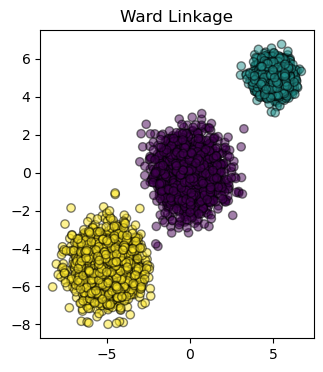

In [19]:
clusterer = AgglomerativeClustering(n_clusters=3)
cluster_labels = clusterer.fit_predict(X)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_scatter(X, cluster_labels)
plt.title("Ward Linkage")

### Generate new samples and plot them along with the original dataset

Text(0.5, 1.0, 'Unknown instances')

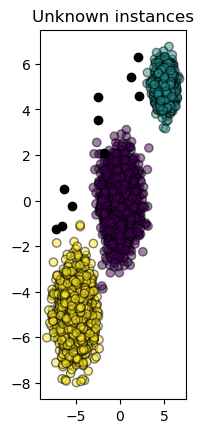

In [20]:
X_new, y_new = make_blobs(
    n_samples=10, centers=[(-7, -1), (-2, 4), (3, 6)], random_state=RANDOM_STATE
)

plt.subplot(132)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, "black", 1)
plt.title("Unknown instances")


### Declare the inductive learning model that it will be used to predict cluster membership for unknown instances

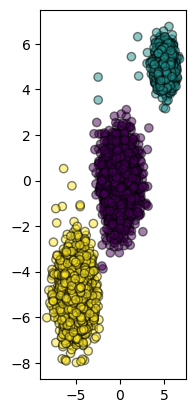

In [21]:
classifier = RandomForestClassifier(random_state=RANDOM_STATE)
inductive_learner = InductiveClusterer(clusterer, classifier).fit(X)

probable_clusters = inductive_learner.predict(X_new)

ax = plt.subplot(133)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, probable_clusters)

### Plotting decision regions

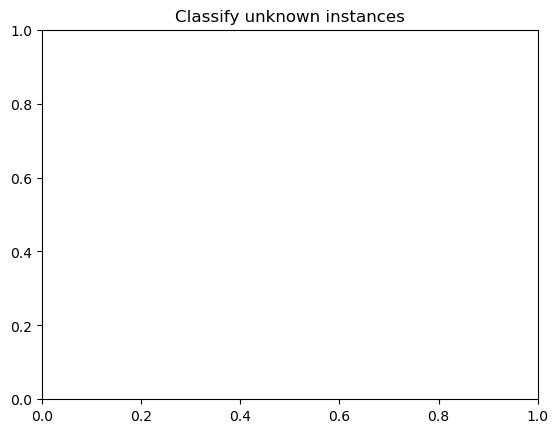

In [22]:
DecisionBoundaryDisplay.from_estimator(
    inductive_learner, X, response_method="predict", alpha=0.4, ax=ax
)
plt.title("Classify unknown instances")

plt.show()